# Notebook to analyze data with interactive graphs

First we need to load all the packages necessary for this notebook. In order to install the packages run pip install requirements.txt

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import os

Next we get the data using the environment variable ```RESEARCH_DATA_PATH``` which should direct to the data folder of this project

In [2]:
# Get the path to the data folder
DATA_PATH = os.environ.get("RESEARCH_DATA_PATH")

# Load the csv files created by the process.py script
gdp_data = pd.read_csv(f'{DATA_PATH}/processed/clean_gdp_data.csv').rename(columns = {'value': 'us_gdp'})
spy_data = pd.read_csv(f'{DATA_PATH}/processed/clean_stock_data.csv')[['date', 'adjusted_close']].rename(columns = {'adjusted_close': 'sp500'})

# Format the date columns as datetime and set them as index column
gdp_data['date'] = gdp_data['date'].apply(pd.to_datetime)
gdp_data.set_index('date', inplace=True)
spy_data['date'] = spy_data['date'].apply(pd.to_datetime)
spy_data.set_index('date', inplace=True)

# Join the data and calculate the percentage growths
close_data = gdp_data.join(spy_data).sort_index()
data = close_data.join(close_data.pct_change(1).rename(columns = {'us_gdp': 'us_gdp_growth', 'sp500': 'sp500_growth'})).sort_index()

In [3]:
spy_data

,sp500
date,
2000-01-01,96.6287
2000-04-01,99.1810
2000-07-01,96.0491
2000-10-01,95.1982
2001-01-01,87.2274
...,...
2022-01-01,469.5288
2022-04-01,447.8475
2022-07-01,375.6944


In [4]:
data

,us_gdp,sp500,us_gdp_growth,sp500_growth
date,,,,
2002-01-01,3263.869,76.9760,NaN,NaN
2002-04-01,3362.508,77.3430,0.030221,0.004768
2002-07-01,3401.820,67.0722,0.011691,-0.132795
2002-10-01,3460.159,55.6833,0.017149,-0.169801
2003-01-01,3340.163,60.3587,-0.034679,0.083964
...,...,...,...,...
2021-07-01,4916.402,420.3074,0.005228,0.083641
2021-10-01,5110.951,422.7312,0.039571,0.005767
2022-01-01,4855.857,469.5288,-0.049911,0.110703


In [5]:
# Write a latex label with summary statistics

data_info = data.describe()
data_info.columns = ['US GDP','SPY 500', 'GDP Growth', 'SPY Growth']

with open('../reports/tables/summary_statistics.tex','w') as tf:
    tf.write(data_info.style.to_latex().replace('%', '\%'))

data_info

,US GDP,SPY 500,GDP Growth,SPY Growth
count,83.000000,83.000000,82.000000,82.000000
mean,4138.823892,162.958013,0.005660,0.023073
std,459.801280,103.134973,0.028586,0.083613
min,3263.869000,55.683300,-0.063206,-0.215656
25%,3825.890000,87.710200,-0.018486,-0.008408
50%,4046.533000,113.518600,0.014289,0.033118
75%,4505.344500,217.391900,0.025628,0.069805
max,5110.951000,469.528800,0.084225,0.201649


In [6]:
# What is the correlation between the two variables

data[['us_gdp', 'sp500']].corr()

,us_gdp,sp500
us_gdp,1.000000,0.913062
sp500,0.913062,1.000000


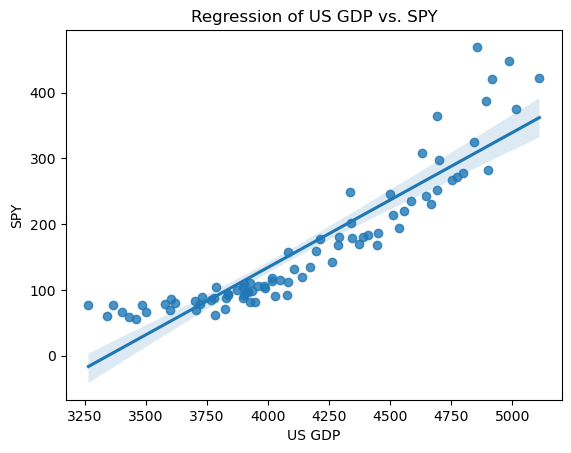

In [7]:
fig = sns.regplot(x=data.us_gdp, y=data.sp500).set(xlabel='US GDP', ylabel='SPY', title='Regression of US GDP vs. SPY');

plt.savefig("../reports/figures/regression.svg")

In [8]:
# Make the two series to start at 100

data_ext = data.copy()

data_ext['us_gdp_100'] = 100*np.exp(np.nan_to_num(data['us_gdp_growth'].cumsum()))
data_ext['sp500_100'] = 100*np.exp(np.nan_to_num(data['sp500_growth'].cumsum()))

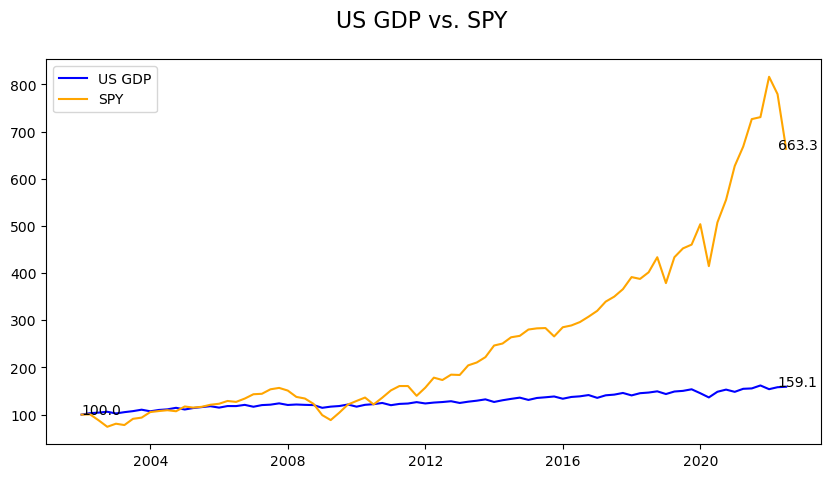

In [9]:
# Plot the two series both starting at 100

fig1, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(data_ext.us_gdp_100, color='blue')
ax1.plot(data_ext.sp500_100, color='orange')

fig1.suptitle('US GDP vs. SPY', fontsize=16)

ax1.legend(['US GDP', 'SPY'], loc='upper left');

ax1.text(data_ext.us_gdp_100.index[-2], data_ext.us_gdp_100[-1], np.round(data_ext.us_gdp_100[-1], 1))
ax1.text(data_ext.sp500_100.index[-2], data_ext.sp500_100[-1], np.round(data_ext.sp500_100[-1], 1))
ax1.text(data_ext.sp500_100.index[0], data_ext.sp500_100[0], np.round(data_ext.sp500_100[0], 1))

plt.savefig("../reports/figures/growth_starting_at_100.svg")

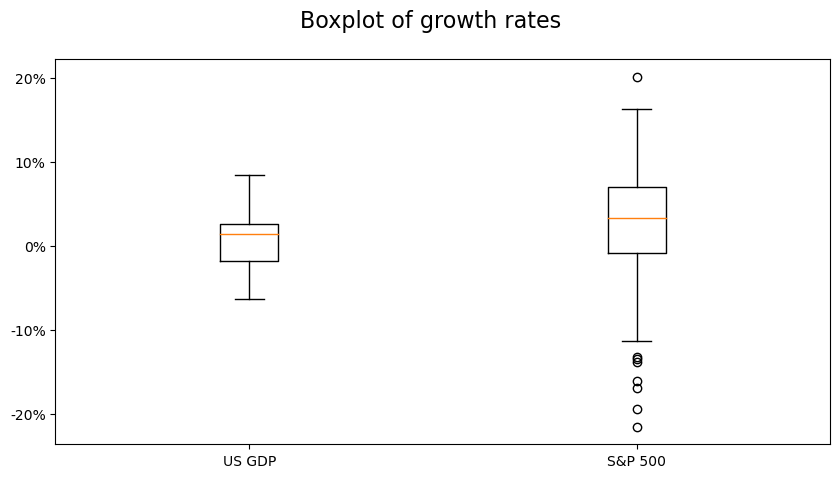

In [10]:
# Add some boxplots

fig2, ax2 = plt.subplots(figsize=(10, 5))
fig2.suptitle('Boxplot of growth rates', fontsize=16)
ax2.boxplot(data[['us_gdp_growth', 'sp500_growth']].dropna())
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax2.set_xticks([1, 2], ['US GDP', 'S&P 500']);

plt.savefig("../reports/figures/boxplots.svg")

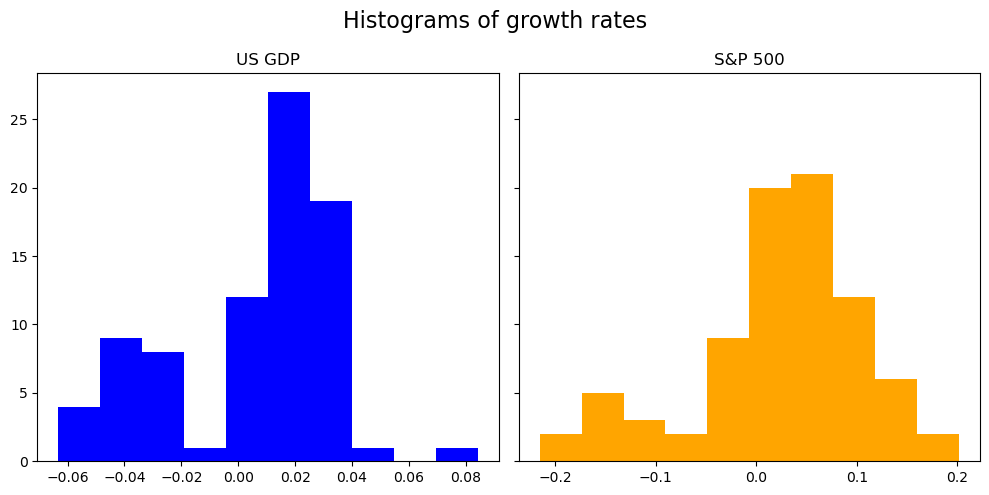

In [11]:
# Add some histograms

fig3, ax3 = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True, tight_layout=True)
fig3.suptitle('Histograms of growth rates', fontsize=16)

ax3[0].set_title('US GDP')
ax3[1].set_title('S&P 500')

ax3[0].hist(data.us_gdp_growth, color = 'blue')
ax3[1].hist(data.sp500_growth, color = 'orange');

plt.savefig("../reports/figures/histograms.svg")

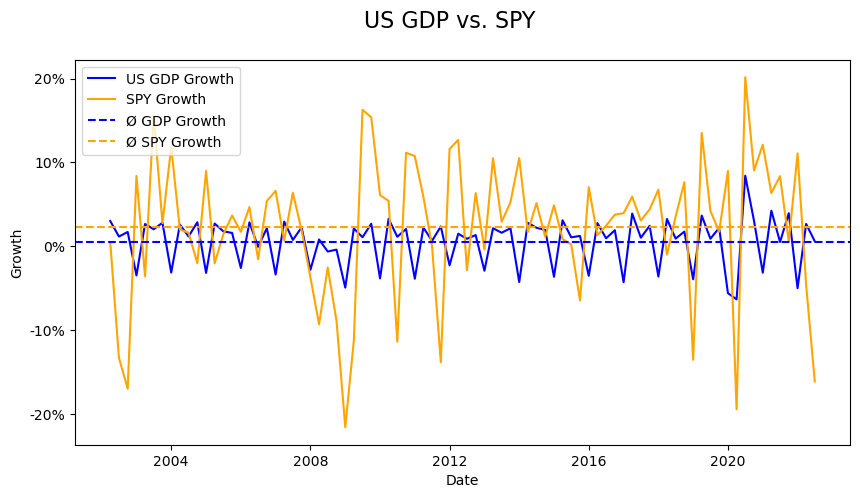

In [12]:
# Plot the growth rates and the average growth over that period

fig4, ax4 = plt.subplots(figsize=(10, 5))

ax4.plot(data.us_gdp_growth, color='blue')
ax4.plot(data.sp500_growth, color='orange')

ax4.axhline(y=np.nanmean(data.us_gdp_growth), color='blue', linestyle='dashed')
ax4.axhline(y=np.nanmean(data.sp500_growth), color='orange', linestyle='dashed')

ax4.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
fig4.suptitle('US GDP vs. SPY', fontsize=16)
ax4.set_ylabel('Growth')
ax4.set_xlabel('Date')
ax4.legend(['US GDP Growth', 'SPY Growth', 'Ø GDP Growth', 'Ø SPY Growth'], loc='upper left');

plt.savefig("../reports/figures/average_growth.svg")

# Analysis with a sample of countries

First, we load the income data retrieved from the World Bank API, since it contains three variables we will be using for our analysis: income level, region and the ISO 2 codes, which will be used to merge the with the gdp and the stock indexes data.

In [13]:
income_data = pd.read_csv(f'{DATA_PATH}/processed/clean_income_data.csv', usecols=["iso2Code", "name", "region", "incomeLevel"])
income_data.rename(columns={"iso2Code":"country", "incomeLevel":"income level"}, inplace=True)
income_data.head()

,country,name,region,income level
0,AF,Afghanistan,South Asia,Low income
1,AL,Albania,Europe & Central Asia,Upper middle income
2,DZ,Algeria,Middle East & North Africa,Lower middle income
3,AS,American Samoa,East Asia & Pacific,Upper middle income
4,AD,Andorra,Europe & Central Asia,High income


Now, we load the data collected for the analysis. It consists of three different data sets, namely:
1. Income level data (already loaded)
2. GDP by for a sample of countries
3. Major stock indexes of a sample of countries

We will combine these three sets of data to perform the same analysis as before, now differetiating by income level and region of the countries in the data. Income level data was obtained from the World Bank API, GDP data from the FRED API using the freadapi python wrapper (only a small subsets of countries had existing data in FRED), and finally, stock indexes were obtained from the Yahoo Finance using the yfinance python package.

In [14]:
gdp_data_all = pd.read_csv(f'{DATA_PATH}/processed/clean_gdp_data_all.csv')
gdp_data_all.rename(columns={"value":"gdp"}, inplace=True)
gdp_data_all["date"] = pd.to_datetime(gdp_data_all.q_date)
gdp_data_all.set_index(["country", "date"], inplace=True)
gdp_data_all.drop("q_date", axis=1, inplace=True)
gdp_data_all.head()

gdp
country date                
AR      2004-01-01  118842.8
        2004-04-01  117587.7
        2004-07-01  123517.5
        2004-10-01  125167.3
        2005-01-01  128814.4

In [15]:
stock_data_all = pd.read_csv(f'{DATA_PATH}/processed/clean_stock_data_all.csv', usecols=["q_date", "value", "country"])
stock_data_all.rename(columns={"value":"stock_index"}, inplace=True)
stock_data_all["date"] = pd.to_datetime(stock_data_all.q_date)
stock_data_all.set_index(["country", "date"], inplace=True)
stock_data_all.drop("q_date", axis=1, inplace=True)
stock_data_all.head()

stock_index
country date                   
US      1927-10-01    17.660000
        1928-01-01    17.760000
        1928-04-01    18.910000
        1928-07-01    18.980000
        1928-10-01    21.360001

In [16]:
data_all = gdp_data_all.join(stock_data_all)
data_all = data_all.sort_index()
data_all.head()

gdp  stock_index
country date                             
AR      2004-01-01  118842.8  1101.500000
        2004-04-01  117587.7  1211.300049
        2004-07-01  123517.5   951.200012
        2004-10-01  125167.3  1160.099976
        2005-01-01  128814.4  1369.500000

Let's see if a there are missing values

In [17]:
np.isnan(data_all).sum()

gdp              0
stock_index    775
dtype: int64

In [18]:
data_all.reset_index().groupby("country").describe()

gdp                                                          \
         count          mean           std           min           25%   
country                                                                  
AR        74.0  1.648458e+05  1.770976e+04  1.175877e+05  1.562278e+05   
AU       252.0  2.461050e+05  1.364541e+05  6.249600e+04  1.304955e+05   
BR       106.0  2.535450e+05  4.646183e+04  1.755276e+05  2.057504e+05   
CA       247.0  2.970836e+05  1.341009e+05  8.589280e+04  1.861689e+05   
DE       127.0  6.279976e+05  7.447596e+04  5.098076e+05  5.643066e+05   
ES       111.0  2.500402e+05  3.384252e+04  1.764704e+05  2.292178e+05   
FR       171.0  4.301038e+05  9.046272e+04  2.790954e+05  3.590940e+05   
GB       271.0  3.201699e+05  1.355410e+05  1.224800e+05  2.051945e+05   
ID        91.0  1.871751e+09  6.055461e+08  1.007085e+09  1.310706e+09   
IT       107.0  4.197239e+05  1.799140e+04  3.557057e+05  4.110570e+05   
JP       115.0  1.271196e+08  7.543063e+06  1.109353e+08  1.205448e+08   
KR       251.0  1.745437e+08  1.575990e+08  7.059600e+06  2.994905e+07   
MX       119.0  3.640065e+06  6.601512e+05  2.434251e+06  3.193807e+06   
PL       110.0  3.429150e+05  1.015078e+05  1.845715e+05  2.506992e+05   
SA        31.0  6.538896e+05  2.428956e+04  6.204372e+05  6.393710e+05   
TR        98.0  3.257049e+05  1.136135e+05  1.805490e+05  2.237649e+05   
US       291.0  2.340458e+06  1.339474e+06  5.465913e+05  1.188096e+06   
ZA       118.0  8.979051e+05  1.960119e+05  5.709373e+05  7.050324e+05   

                                                  stock_index                \
                  50%           75%           max       count          mean   
country                                                                       
AR       1.726856e+05  1.777659e+05  1.845179e+05        74.0  15191.005471   
AU       2.090675e+05  3.580618e+05  5.330920e+05       119.0   4249.692432   
BR       2.640142e+05  2.963465e+05  3.125251e+05       106.0  47109.329244   
CA       2.725043e+05  4.227488e+05  5.417187e+05       174.0   8366.598247   
DE       6.156690e+05  6.864872e+05  7.510318e+05       127.0   6634.829609   
ES       2.609639e+05  2.741608e+05  2.977550e+05       111.0   9046.611759   
FR       4.491477e+05  5.105434e+05  5.695848e+05       131.0   3938.735507   
GB       3.146630e+05  4.565650e+05  5.614800e+05       155.0   4716.926449   
ID       1.807993e+09  2.417032e+09  2.919293e+09        91.0   3326.695588   
IT       4.235506e+05  4.306893e+05  4.534805e+05       100.0  26279.560000   
JP       1.288526e+08  1.334827e+08  1.394330e+08       115.0  16162.417965   
KR       1.241553e+08  3.113398e+08  4.933208e+08       104.0   1544.730764   
MX       3.649058e+06  4.247532e+06  4.645932e+06       119.0  24360.847759   
PL       3.391602e+05  4.184353e+05  5.604802e+05         0.0           NaN   
SA       6.461080e+05  6.621794e+05  7.304161e+05         0.0           NaN   
TR       2.916527e+05  4.191330e+05  5.687939e+05        98.0  46273.371248   
US       2.047638e+06  3.597606e+06  5.005430e+06       291.0    717.041377   
ZA       9.522435e+05  1.091109e+06  1.152273e+06         0.0           NaN   

                                                                               \
                  std           min           25%           50%           75%   
country                                                                         
AR       20717.332802    951.200012   2119.975098   3434.000000  24527.750000   
AU        1573.024145   1455.000000   2963.099976   4329.299805   5412.550049   
BR       31934.126182   4390.100098  15458.500000  50034.500000  63395.500000   
CA        5303.849577   1356.546387   3445.951843   7254.199951  12911.875244   
DE        3849.331692   1359.430054   3879.845093   5999.459961   9527.000000   
ES        2490.989841   2933.297119   7934.041992   9264.599609  10456.588867   
FR        1422.678010   1505.000000   2883.220093   4054.540039   5

PL, SA and ZA have missing values for the stock index, remove such countries from the data

In [19]:
data_all = data_all.reset_index().loc[~data_all.reset_index().country.isin(["PL", "SA", "ZA"]), :]
data_all.set_index(["country", "date"], inplace=True)
data_all.head()

gdp  stock_index
country date                             
AR      2004-01-01  118842.8  1101.500000
        2004-04-01  117587.7  1211.300049
        2004-07-01  123517.5   951.200012
        2004-10-01  125167.3  1160.099976
        2005-01-01  128814.4  1369.500000

What is the correlations between the two variables, without considering the cross-section?

In [20]:
data_all.corr()

,gdp,stock_index
gdp,1.000000,-0.114588
stock_index,-0.114588,1.000000


What if we include the cross-section?

In [21]:
data_all.reset_index("country").groupby("country").corr()

gdp  stock_index
country                                   
AR      gdp          1.000000     0.344799
        stock_index  0.344799     1.000000
AU      gdp          1.000000     0.929147
        stock_index  0.929147     1.000000
BR      gdp          1.000000     0.859534
        stock_index  0.859534     1.000000
CA      gdp          1.000000     0.972852
        stock_index  0.972852     1.000000
DE      gdp          1.000000     0.943199
        stock_index  0.943199     1.000000
ES      gdp          1.000000     0.567104
        stock_index  0.567104     1.000000
FR      gdp          1.000000     0.781433
        stock_index  0.781433     1.000000
GB      gdp          1.000000     0.926161
        stock_index  0.926161     1.000000
ID      gdp          1.000000     0.976335
        stock_index  0.976335     1.000000
IT      gdp          1.000000     0.233223
        stock_index  0.233223     1.000000
JP      gdp          1.000000     0.289391
        stock_index  0.289391     1.000000
KR      gdp          1.000000     0.942215
        stock_index  0.942215     1.000000
MX      gdp          1.000000     0.955407
        stock_index  0.955407     1.000000
TR      gdp          1.000000     0.586082
        stock_index  0.586082     1.000000
US      gdp          1.000000     0.883822
        stock_index  0.883822     1.000000

We see that the correlation between the two variables is higher for some countries than for others, but always positive. Let's add some more characteristics of the countries to do the cross-sectional analysis with more variables considered

In [22]:
income_data.set_index("country", inplace=True)

In [23]:
data_all = data_all.join(income_data)
data_all.head()

gdp  stock_index       name  \
country date                                           
AR      2004-01-01  118842.8  1101.500000  Argentina   
        2004-04-01  117587.7  1211.300049  Argentina   
        2004-07-01  123517.5   951.200012  Argentina   
        2004-10-01  125167.3  1160.099976  Argentina   
        2005-01-01  128814.4  1369.500000  Argentina   

                                        region         income level  
country date                                                         
AR      2004-01-01  Latin America & Caribbean   Upper middle income  
        2004-04-01  Latin America & Caribbean   Upper middle income  
        2004-07-01  Latin America & Caribbean   Upper middle income  
        2004-10-01  Latin America & Caribbean   Upper middle income  
        2005-01-01  Latin America & Caribbean   Upper middle income

Now, we will obtain the percentage changes of the two series, and make them start at 100 using those changes. This has to be done for each country. To avoid mistakes, it will be done in a loop. Although inefficient, calculations using grouped operations might be too cumbersome and could lead to errors. Also, the data will be filtrated to keep only data from year 2000 onwards.

In [24]:
data_all = data_all.loc[data_all.index.get_level_values("date") >= "2000-01-01", :]
countries = data_all.index.get_level_values("country").unique()
print(countries)

Index(['AR', 'AU', 'BR', 'CA', 'DE', 'ES', 'FR', 'GB', 'ID', 'IT', 'JP', 'KR',
       'MX', 'TR', 'US'],
      dtype='object', name='country')


In [25]:
# Do the calculations for each country
data_all.reset_index(inplace=True)
data = pd.DataFrame()
for c in countries:
    aux_d = data_all.loc[data_all.country == c, :]
    aux_d.sort_values("date", inplace=True)
    aux_d["gdp_growth"] = aux_d.gdp.pct_change(1)
    aux_d["stock_index_growth"] = aux_d.stock_index.pct_change(1)
    aux_d["gdp_100"] = 100*np.exp(np.nan_to_num(aux_d["gdp_growth"].cumsum()))
    aux_d["stock_index_100"] = 100*np.exp(np.nan_to_num(aux_d["stock_index_growth"].cumsum()))
    data = pd.concat([data, aux_d])

data.set_index(["country", "date"], inplace=True)
data.head()


/var/folders/d4/9bzzss954hn8n537wrw0mjn80000gn/T/ipykernel_7246/1079080424.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_d.sort_values("date", inplace=True)
/var/folders/d4/9bzzss954hn8n537wrw0mjn80000gn/T/ipykernel_7246/1079080424.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_d["gdp_growth"] = aux_d.gdp.pct_change(1)
/var/folders/d4/9bzzss954hn8n537wrw0mjn80000gn/T/ipykernel_7246/1079080424.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


gdp  stock_index       name  \
country date                                           
AR      2004-01-01  118842.8  1101.500000  Argentina   
        2004-04-01  117587.7  1211.300049  Argentina   
        2004-07-01  123517.5   951.200012  Argentina   
        2004-10-01  125167.3  1160.099976  Argentina   
        2005-01-01  128814.4  1369.500000  Argentina   

                                        region         income level  \
country date                                                          
AR      2004-01-01  Latin America & Caribbean   Upper middle income   
        2004-04-01  Latin America & Caribbean   Upper middle income   
        2004-07-01  Latin America & Caribbean   Upper middle income   
        2004-10-01  Latin America & Caribbean   Upper middle income   
        2005-01-01  Latin America & Caribbean   Upper middle income   

                    gdp_growth  stock_index_growth     gdp_100  \
country date                                                     
AR      2004-01-01         NaN                 NaN  100.000000   
        2004-04-01   -0.010561            0.099682   98.949456   
        2004-07-01    0.050429           -0.214728  104.067312   
        2004-10-01    0.013357            0.219617  105.466644   
        2005-01-01    0.029138            0.180502  108.584919   

                    stock_index_100  
country date                         
AR      2004-01-01       100.000000  
        2004-04-01       110.481986  
        2004-07-01        89.132541  
        2004-10-01       111.023486  
        2005-01-01       132.985948

In [26]:
data.tail()

gdp  stock_index           name         region  \
country date                                                               
US      2021-07-01  4918148.5  4319.939941  United States  North America   
        2021-10-01  5001545.3  4357.040039  United States  North America   
        2022-01-01  4981022.0  4796.560059  United States  North America   
        2022-04-01  4973817.8  4545.859863  United States  North America   
        2022-07-01  5005430.3  3825.330078  United States  North America   

                   income level  gdp_growth  stock_index_growth     gdp_100  \
country date                                                                  
US      2021-07-01  High income    0.006567            0.074647  153.525061   
        2021-10-01  High income    0.016957            0.008588  156.150575   
        2022-01-01  High income   -0.004103            0.100876  155.511141   
        2022-04-01  High income   -0.001446           -0.052267  155.286383   
        2022-07-01  High income    0.006356           -0.158502  156.276493   

                    stock_index_100  
country date                         
US      2021-07-01       416.281236  
        2021-10-01       419.871699  
        2022-01-01       464.436579  
        2022-04-01       440.785494  
        2022-07-01       376.175552

In [27]:
# Write a latex label with summary statistics

data_info = data.reset_index("country").groupby("country").describe()

with open('../reports/tables/summary_statistics_all.tex','w') as tf:
    tf.write(data_info.style.to_latex().replace('%', '\%'))

data_info

gdp                                                          \
        count          mean           std           min           25%   
country                                                                 
AR       74.0  1.648458e+05  1.770976e+04  1.175877e+05  1.562278e+05   
AU       90.0  4.076363e+05  7.009787e+04  2.909350e+05  3.485542e+05   
BR       90.0  2.656519e+05  3.952238e+04  1.923737e+05  2.277440e+05   
CA       91.0  4.506457e+05  5.245685e+04  3.567058e+05  4.152224e+05   
DE       91.0  6.638544e+05  5.500700e+04  5.856618e+05  6.077054e+05   
ES       91.0  2.630278e+05  2.070193e+04  2.138003e+05  2.543291e+05   
FR       91.0  5.059316e+05  3.651228e+04  4.352118e+05  4.780205e+05   
GB       91.0  4.853553e+05  4.543505e+04  4.034070e+05  4.565650e+05   
ID       91.0  1.871751e+09  6.055461e+08  1.007085e+09  1.310706e+09   
IT       91.0  4.249940e+05  1.347776e+04  3.557057e+05  4.174370e+05   
JP       91.0  1.299189e+08  5.669525e+06  1.199650e+08  1.255584e+08   
KR       91.0  3.622563e+08  8.037743e+07  2.207863e+08  2.930120e+08   
MX       91.0  3.911306e+06  4.910995e+05  3.181912e+06  3.472522e+06   
TR       90.0  3.380496e+05  1.103599e+05  1.815463e+05  2.510749e+05   
US       91.0  4.066229e+06  4.953267e+05  3.233813e+06  3.749690e+06   

                                                  stock_index                \
                  50%           75%           max       count          mean   
country                                                                       
AR       1.726856e+05  1.777659e+05  1.845179e+05        74.0  15191.005471   
AU       4.036625e+05  4.681352e+05  5.330920e+05        90.0   4900.231109   
BR       2.869763e+05  2.994347e+05  3.125251e+05        90.0  53904.655556   
CA       4.451525e+05  4.914619e+05  5.417187e+05        91.0  12677.131890   
DE       6.629973e+05  7.136714e+05  7.510318e+05        91.0   8151.402094   
ES       2.674758e+05  2.779358e+05  2.977550e+05        91.0   9612.303711   
FR       5.080741e+05  5.312358e+05  5.695848e+05        91.0   4616.372323   
GB       4.782420e+05  5.231480e+05  5.614800e+05        91.0   5995.343946   
ID       1.807993e+09  2.417032e+09  2.919293e+09        91.0   3326.695588   
IT       4.250389e+05  4.314298e+05  4.534805e+05        91.0  25647.538462   
JP       1.306510e+08  1.345143e+08  1.394330e+08        91.0  15681.777542   
KR       3.688415e+08  4.329462e+08  4.933208e+08        91.0   1678.548237   
MX       3.815792e+06  4.404713e+06  4.645932e+06        91.0  30838.043779   
TR       3.164369e+05  4.315819e+05  5.687939e+05        90.0  50033.584248   
US       3.967671e+06  4.442131e+06  5.005430e+06        91.0   1833.512205   

         ...     gdp_100             stock_index_100               \
         ...         75%         max           count         mean   
country  ...                                                        
AR       ...  151.841534  158.103474            74.0  4558.976658   
AU       ...  161.635838  184.626746            90.0   180.897599   
BR       ...  156.643011  164.465263            90.0   575.869091   
CA       ...  138.062288  153.946637            91.0   186.050732   
DE       ...  122.240516  129.857484            91.0   194.103179   
ES       ...  130.618241  141.387372            91.0   108.507336   
FR       ...  122.305831  134.679096            91.0   103.600403   
GB       ...  130.560276  144.933742            91.0   103.836774   
ID       ...  240.203447  291.603628            91.0   786.700243   
IT       ...  105.637144  110.562613            91.0    81.529280   
JP       ...  112.725789  116.692986            91.0   112.233852   
KR       ...  197.267683  225.154371            91.0   250.666526   
MX       ...  139.630704  150.569135            91.0   613.369899   
TR       ...  234.545835  314.224809            90.0   843.003757   
US       ...  137.640311  156.276493            91.0   155.056367   

                             

Correlation by region and income level

In [28]:
# Income level
data.reset_index()[["region", "gdp", "stock_index"]].groupby("region").corr()

gdp  stock_index
region                                                       
East Asia & Pacific        gdp          1.000000    -0.241008
                           stock_index -0.241008     1.000000
Europe & Central Asia      gdp          1.000000    -0.181261
                           stock_index -0.181261     1.000000
Latin America & Caribbean  gdp          1.000000    -0.023447
                           stock_index -0.023447     1.000000
North America              gdp          1.000000    -0.861113
                           stock_index -0.861113     1.000000

In [29]:
data.reset_index()[["income level", "gdp", "stock_index"]].groupby("income level").corr()

gdp  stock_index
income level                                          
High income         gdp          1.000000    -0.198527
                    stock_index -0.198527     1.000000
Lower middle income gdp          1.000000     0.976335
                    stock_index  0.976335     1.000000
Upper middle income gdp          1.000000    -0.080515
                    stock_index -0.080515     1.000000

In all instances of regions, the two variables appear to be negative correlated, or with a correlation close to zero. Largest negative correlation corresponding to North America.
By income level, the two variables are negatively correlated for high income and upper-middle income, and very positively correlated for lower-middle income countries.

Some visualizations

/Users/lesfa/miniforge3/envs/scikit_learn/lib/python3.10/site-packages/seaborn/regression.py:582: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/Users/lesfa/miniforge3/envs/scikit_learn/lib/python3.10/site-packages/seaborn/regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


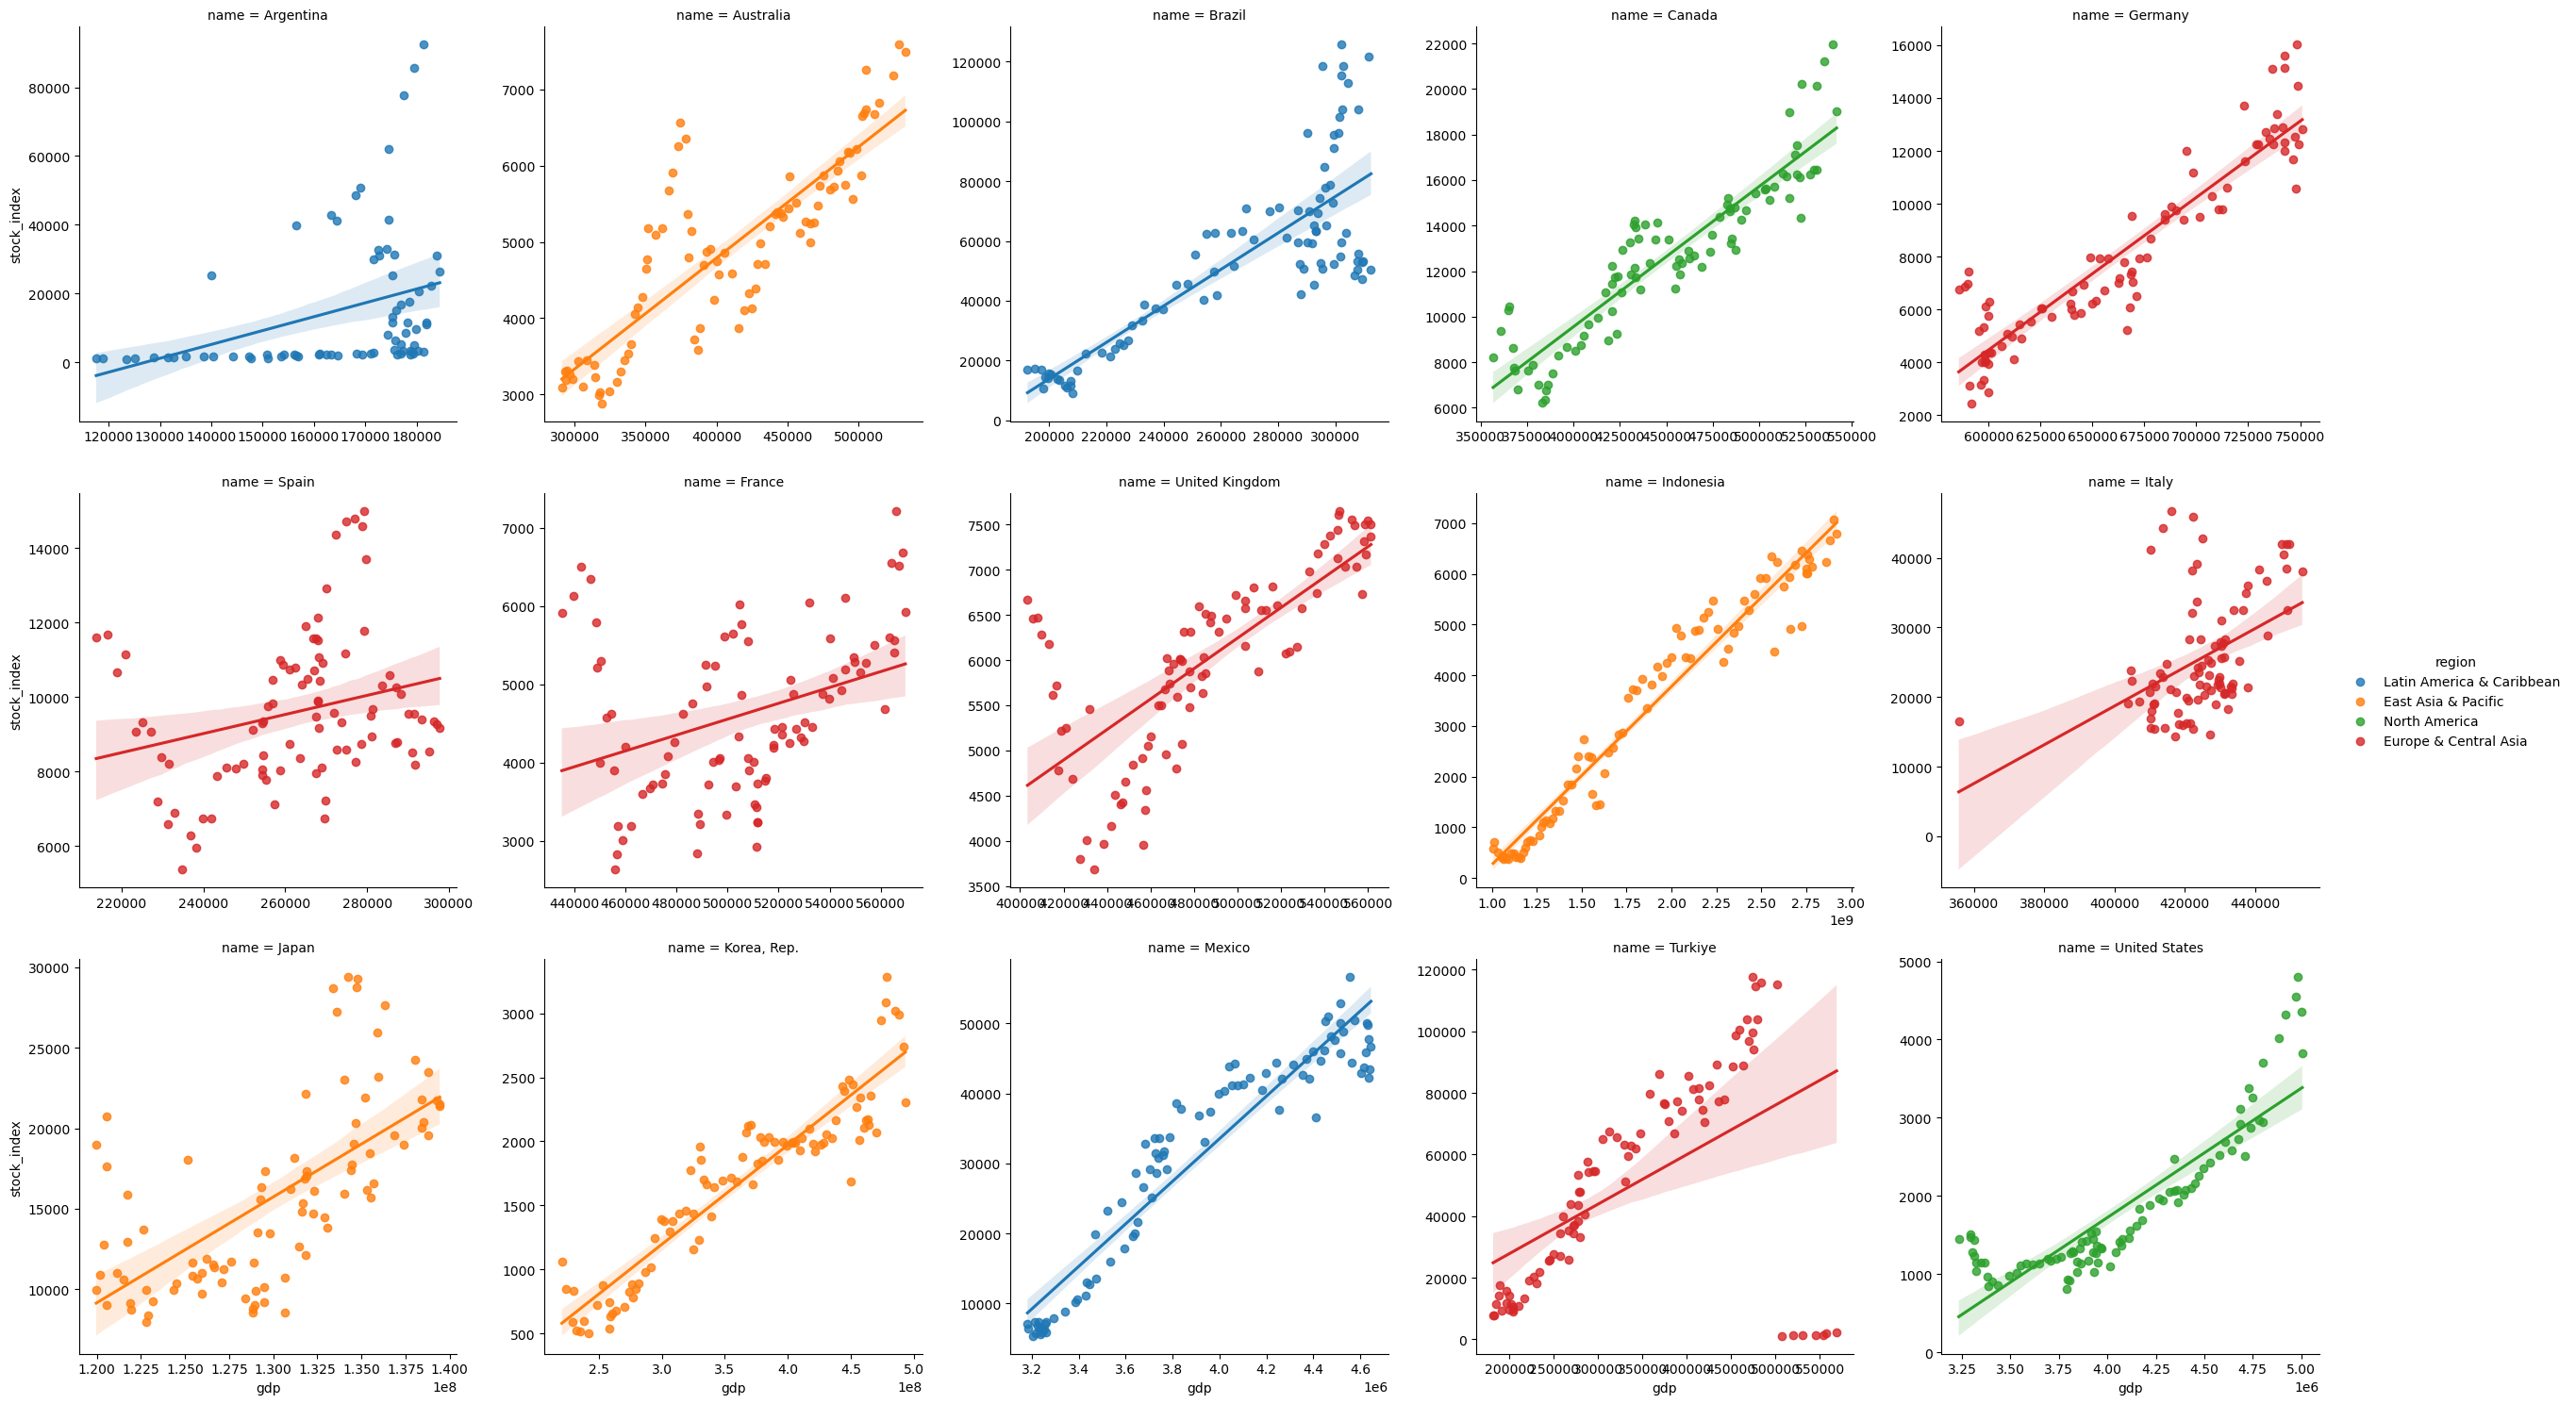

In [30]:
sns.lmplot(data=data.reset_index(), x="gdp", y="stock_index", col="name", col_wrap=5, sharex=False, sharey=False, hue="region")
plt.savefig("../reports/figures/regression_all_region.svg")

/Users/lesfa/miniforge3/envs/scikit_learn/lib/python3.10/site-packages/seaborn/regression.py:582: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/Users/lesfa/miniforge3/envs/scikit_learn/lib/python3.10/site-packages/seaborn/regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


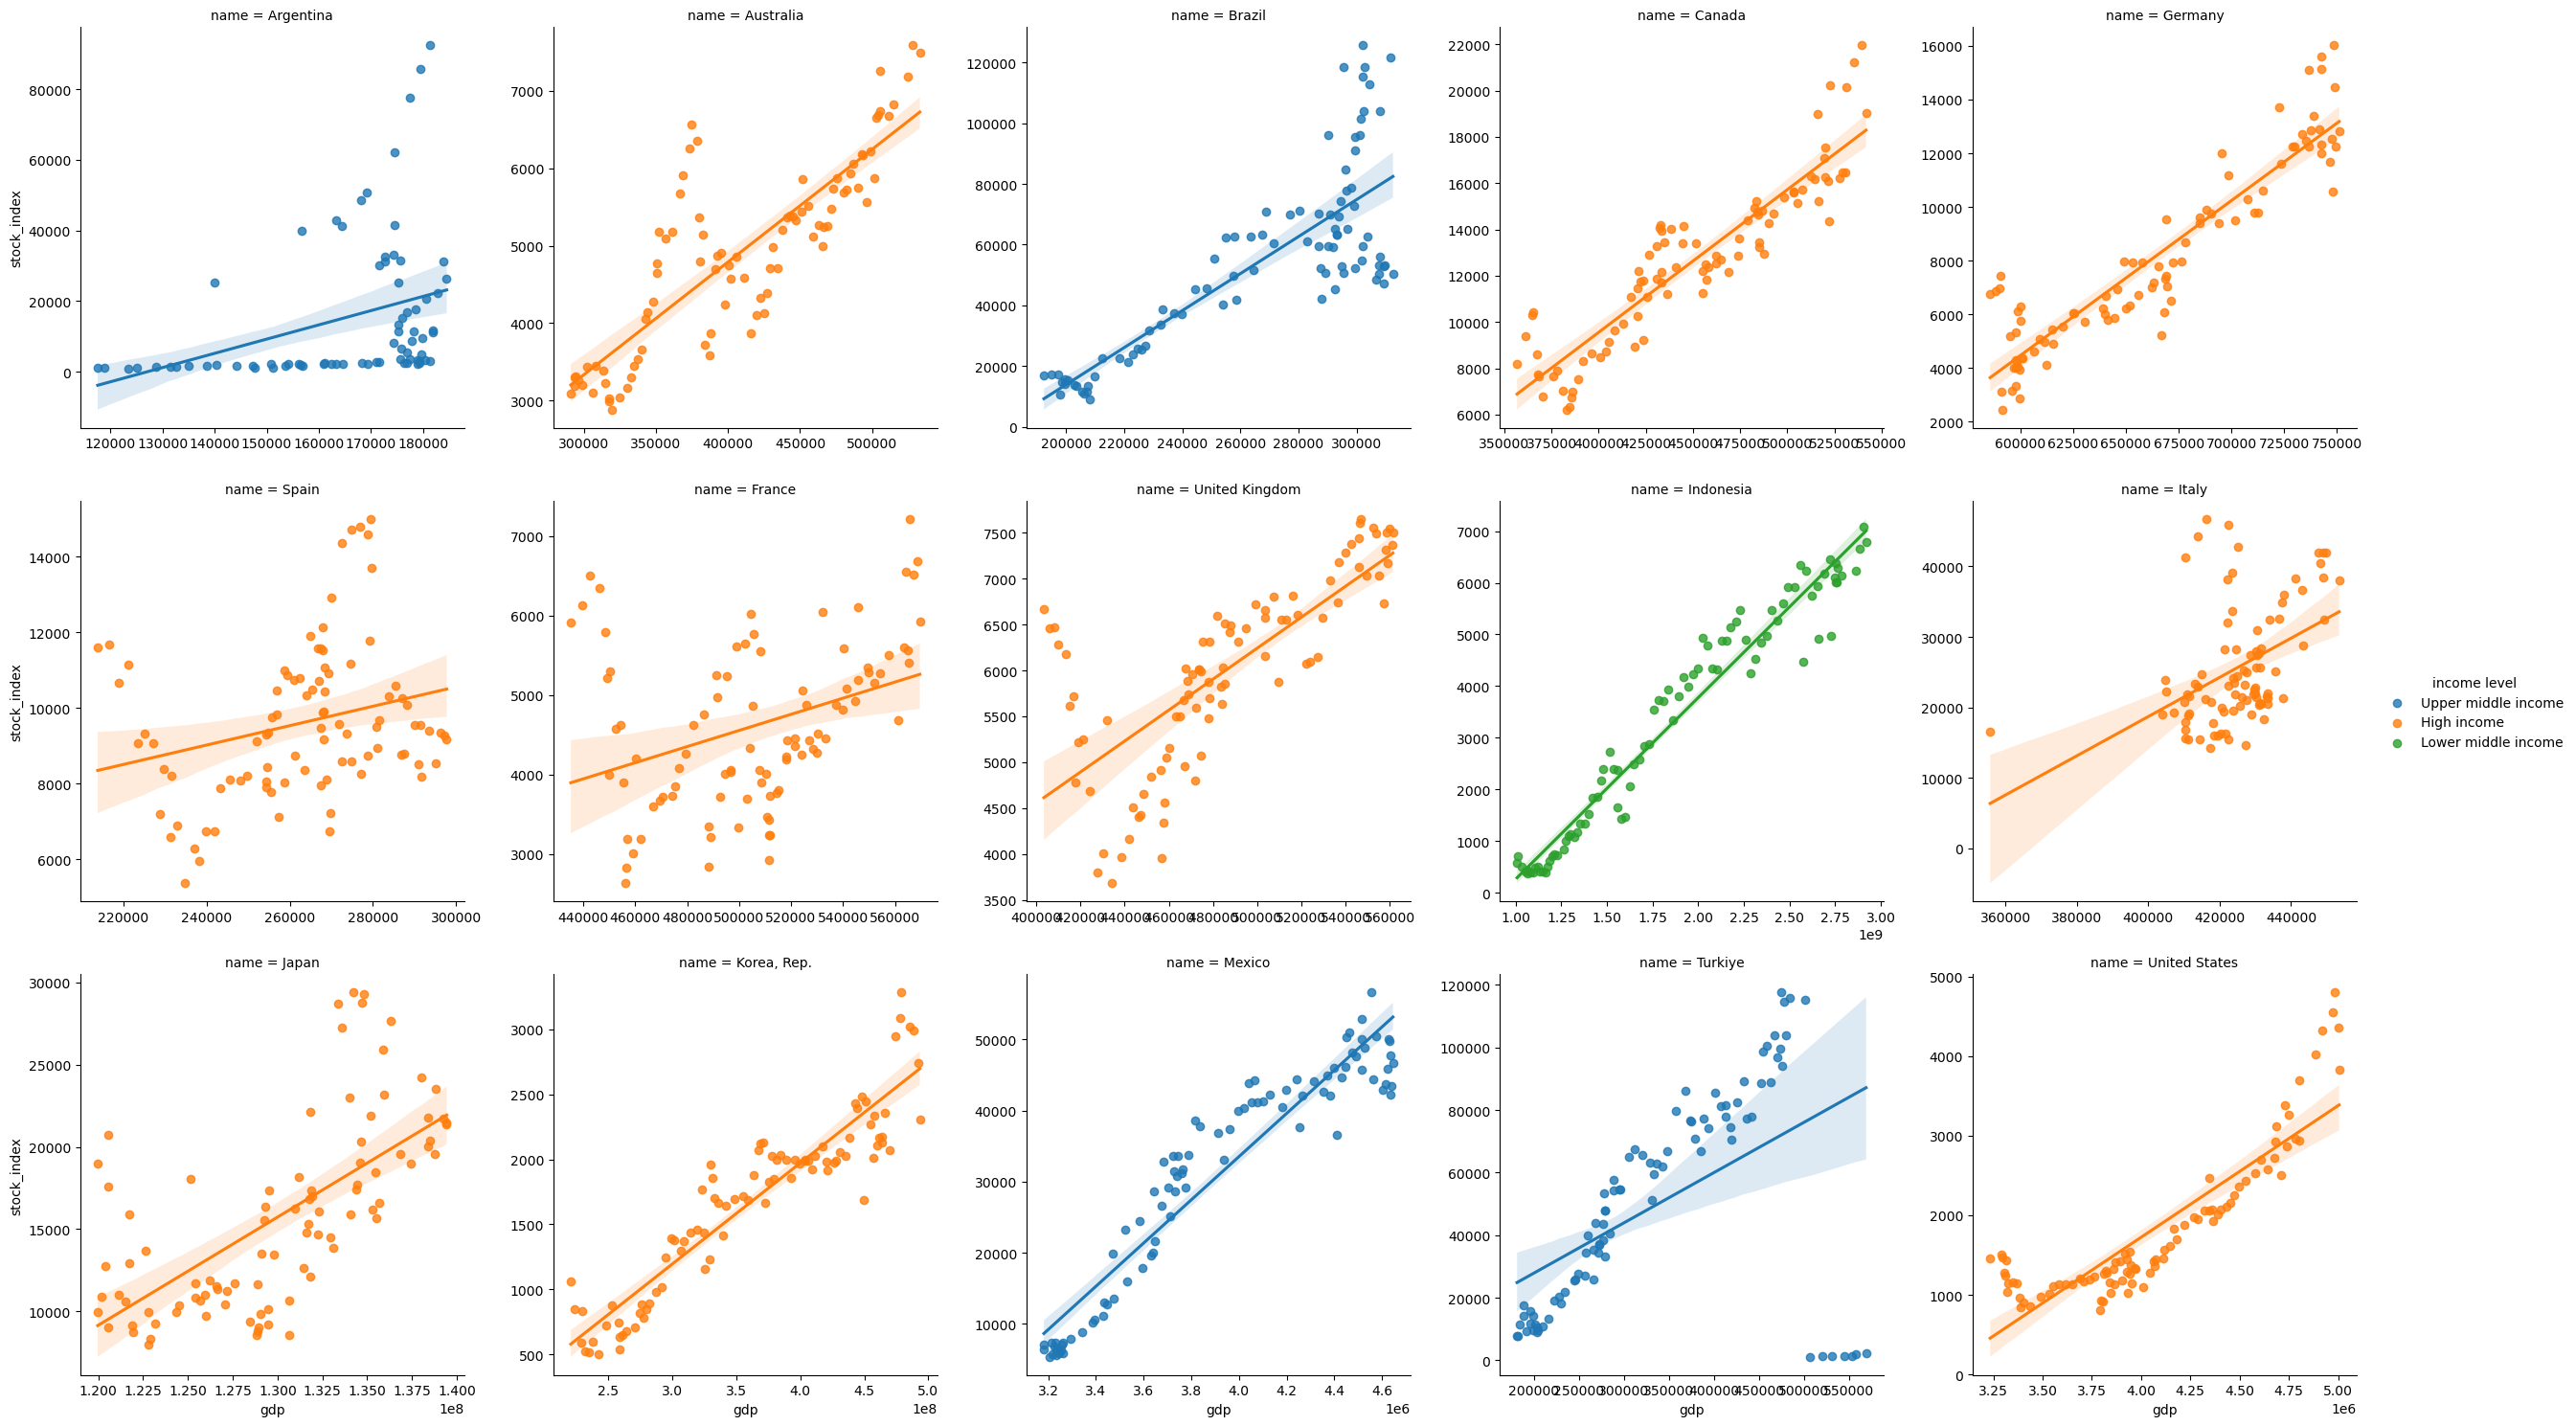

In [31]:
sns.lmplot(data=data.reset_index(), x="gdp", y="stock_index", col="name", col_wrap=5, sharex=False, sharey=False, hue="income level")
plt.savefig("../reports/figures/regression_all_incomelevel.svg")

Reshaping the data for another visualization

In [40]:
ad1 = data[["name", "gdp_100", "stock_index_100"]].reset_index().melt(id_vars=["country", "name", "date"])
ad1.head()

,country,name,date,variable,value
0,AR,Argentina,2004-01-01,gdp_100,100.000000
1,AR,Argentina,2004-04-01,gdp_100,98.949456
2,AR,Argentina,2004-07-01,gdp_100,104.067312
3,AR,Argentina,2004-10-01,gdp_100,105.466644
4,AR,Argentina,2005-01-01,gdp_100,108.584919


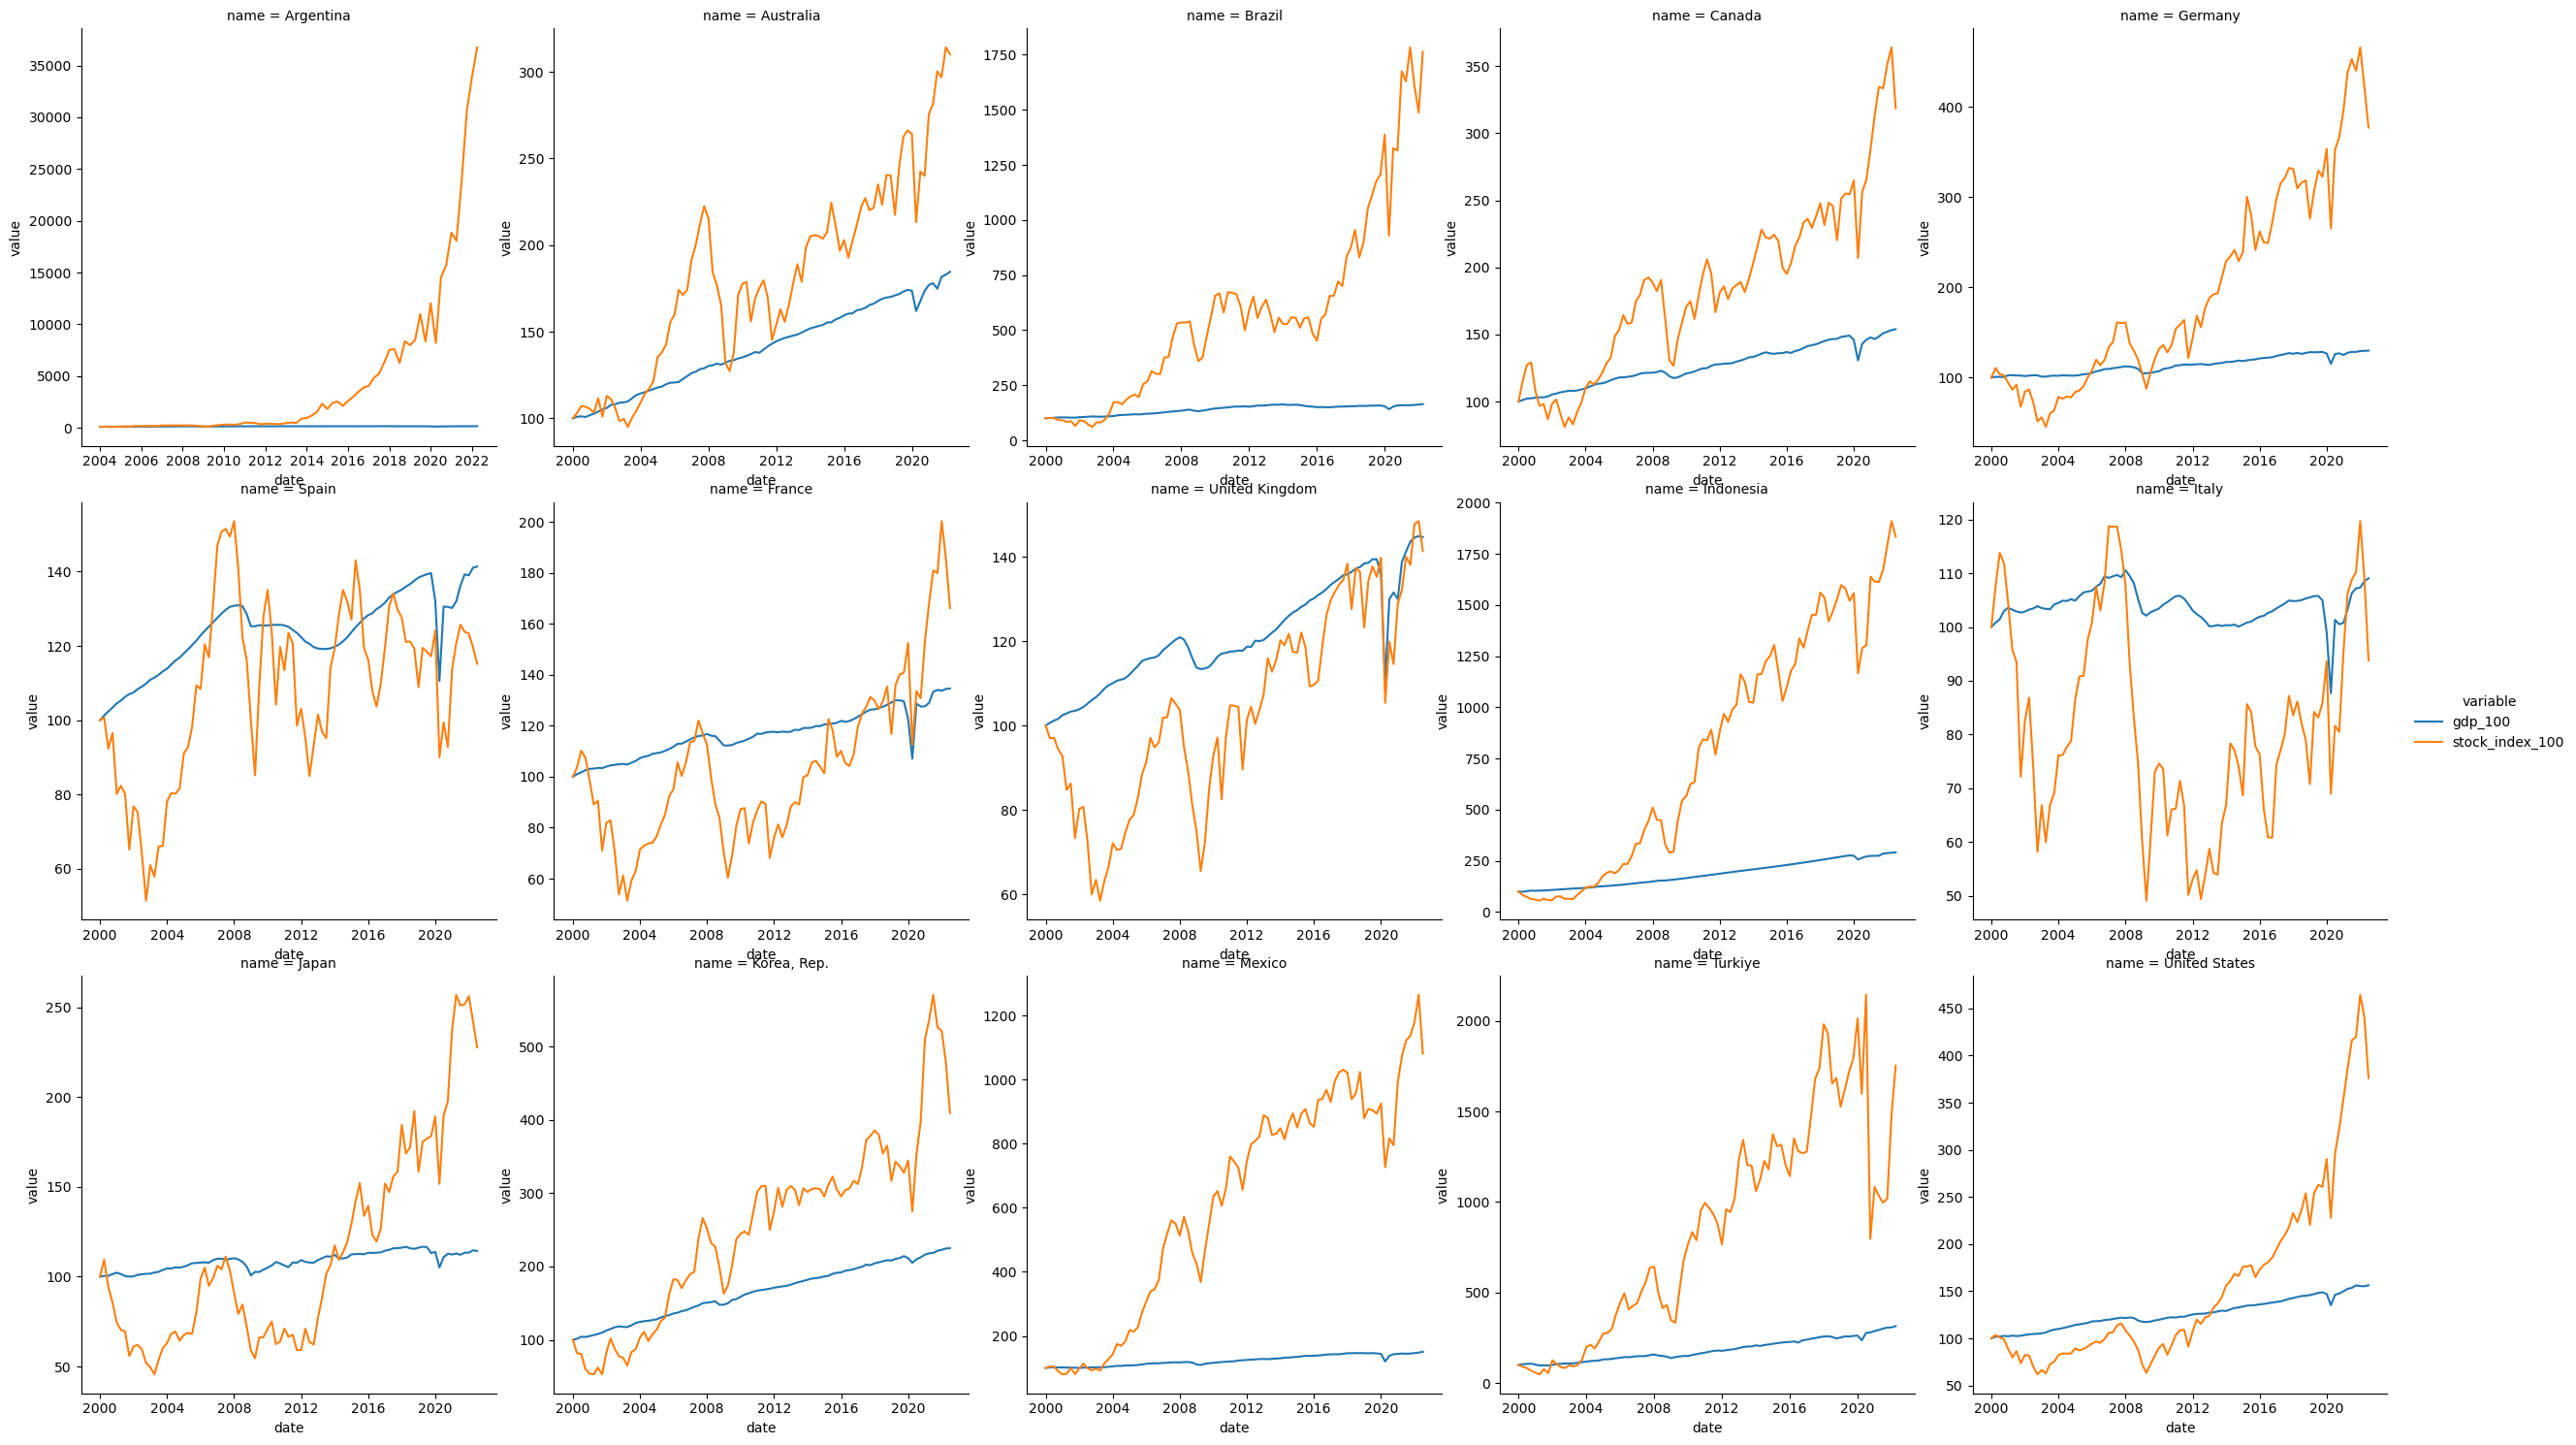

In [41]:
sns.relplot(data=ad1, x="date", y="value", hue="variable", col="name", col_wrap=5, kind="line", facet_kws=dict(sharey=False, sharex=False))

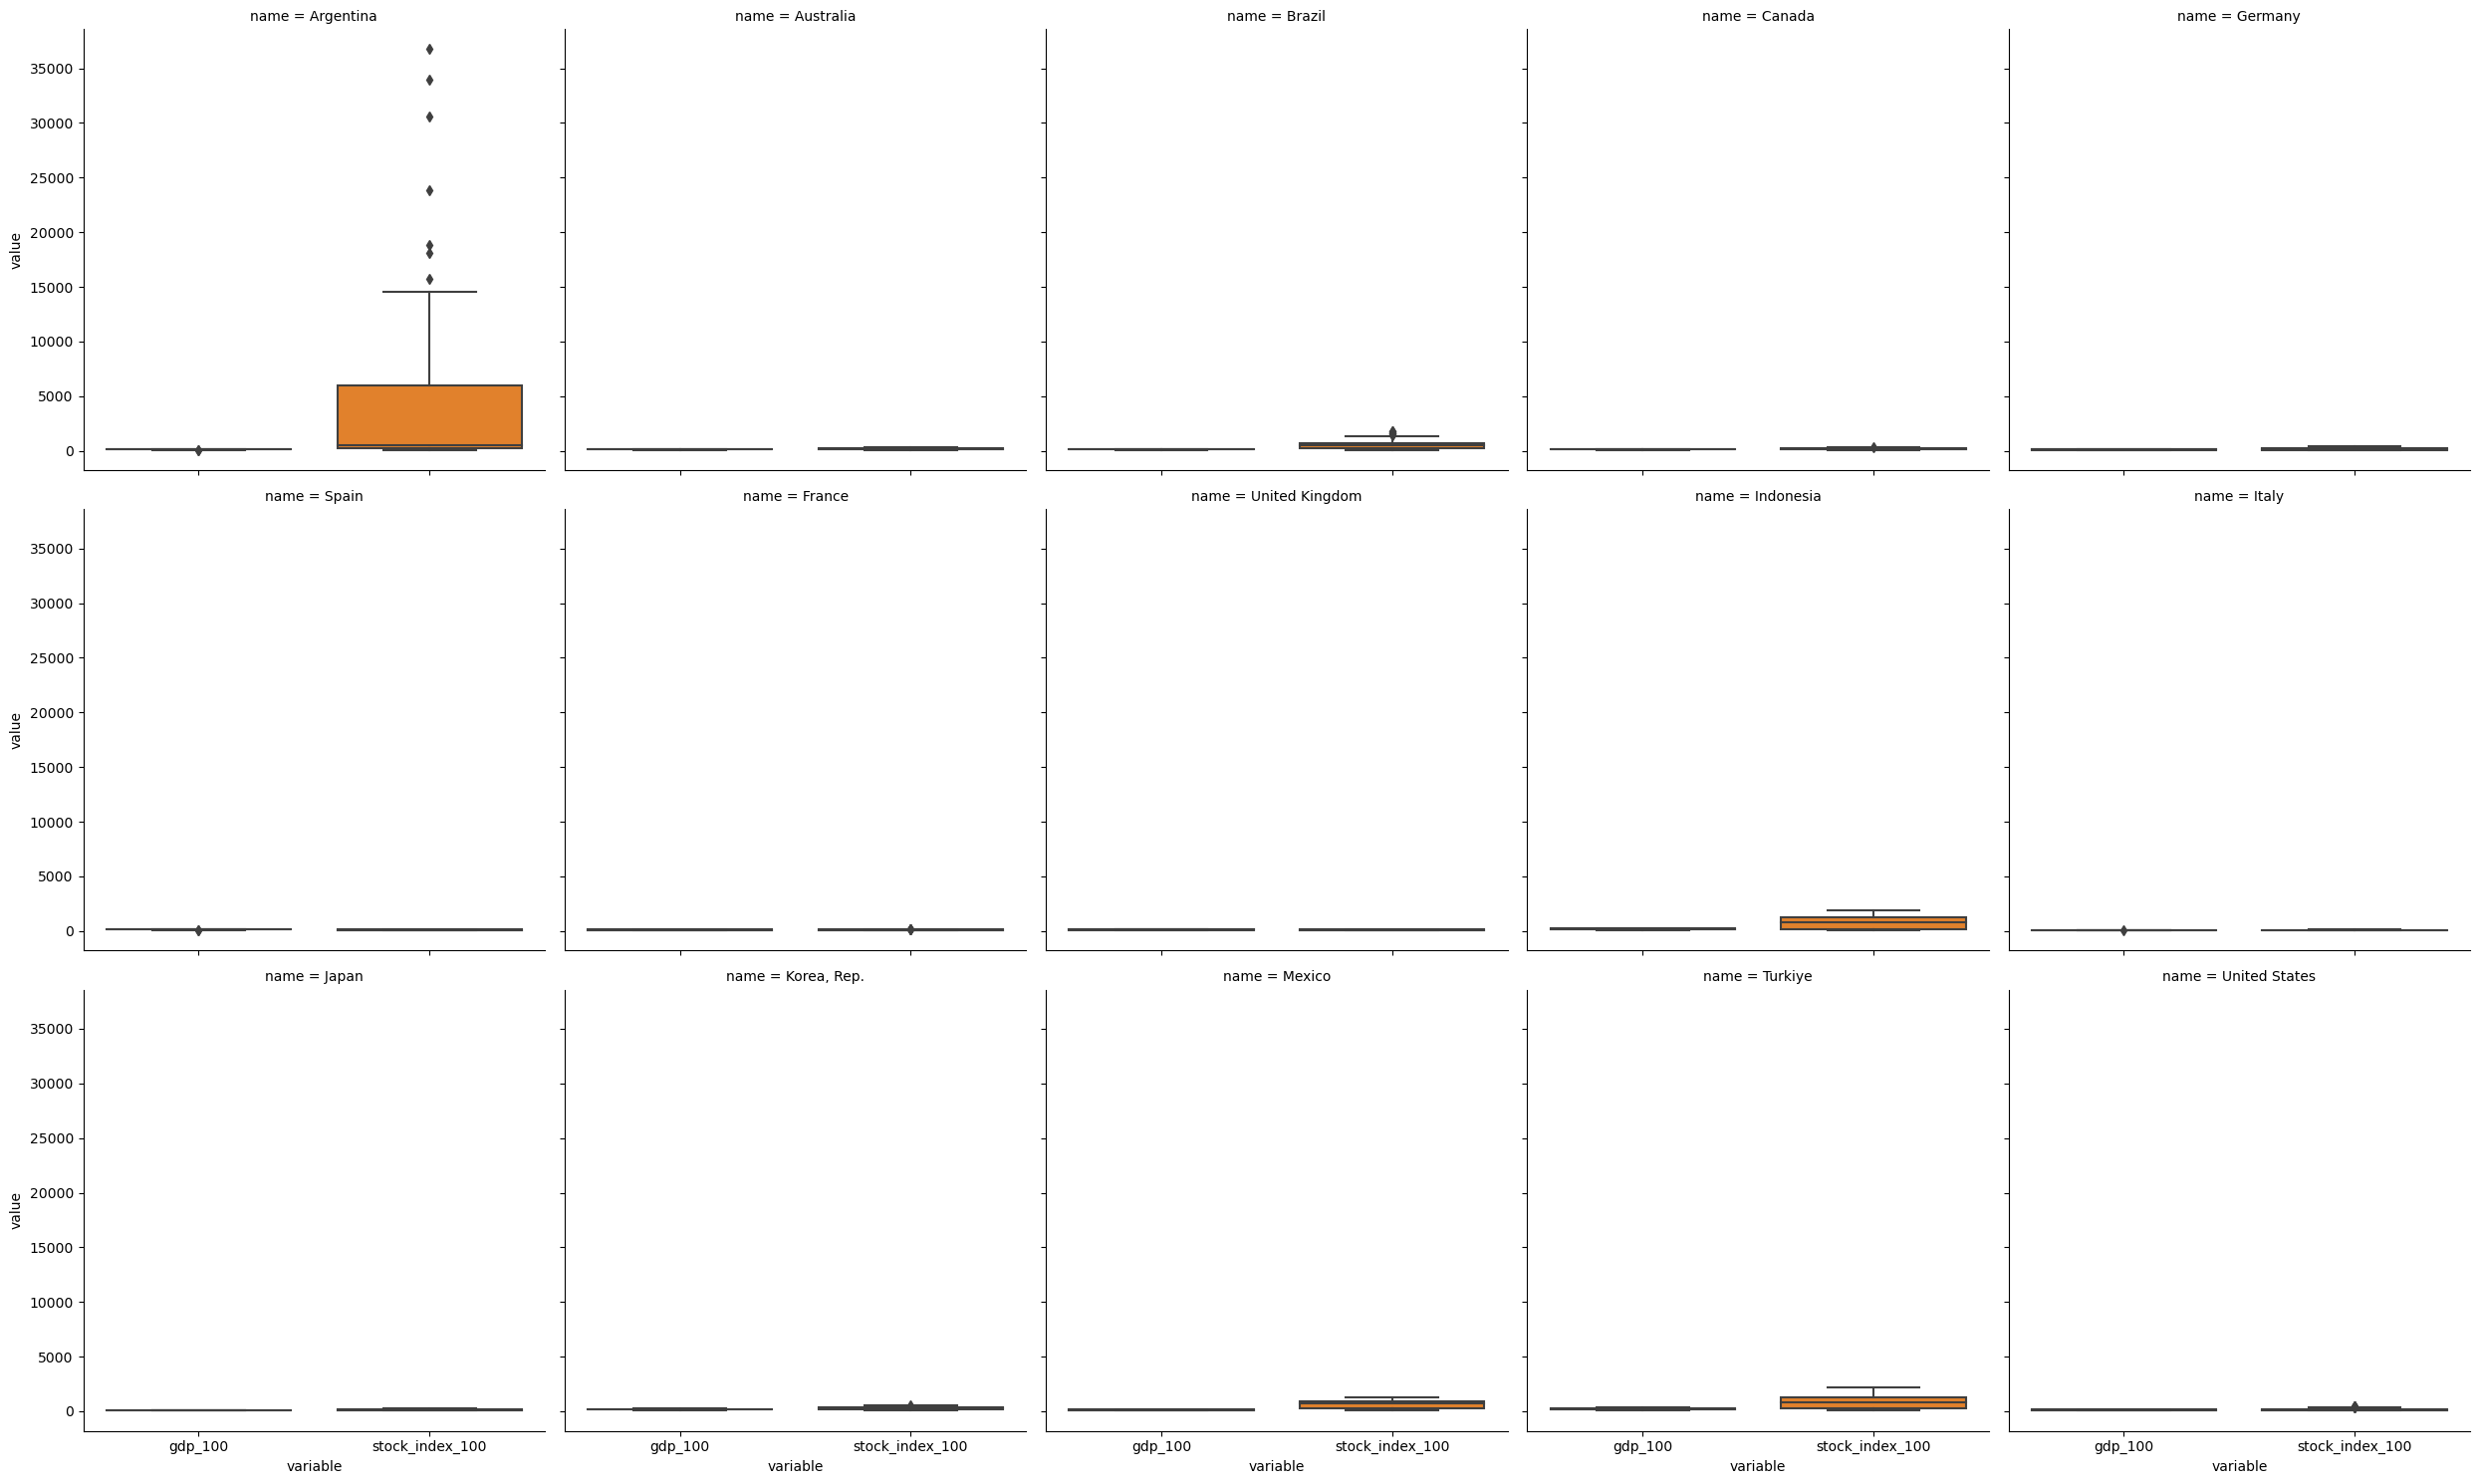

In [44]:
sns.catplot(data=ad1, x="variable", y="value", col="name", col_wrap=5, kind="box", facet_kws=dict(sharey=False, sharex=True))

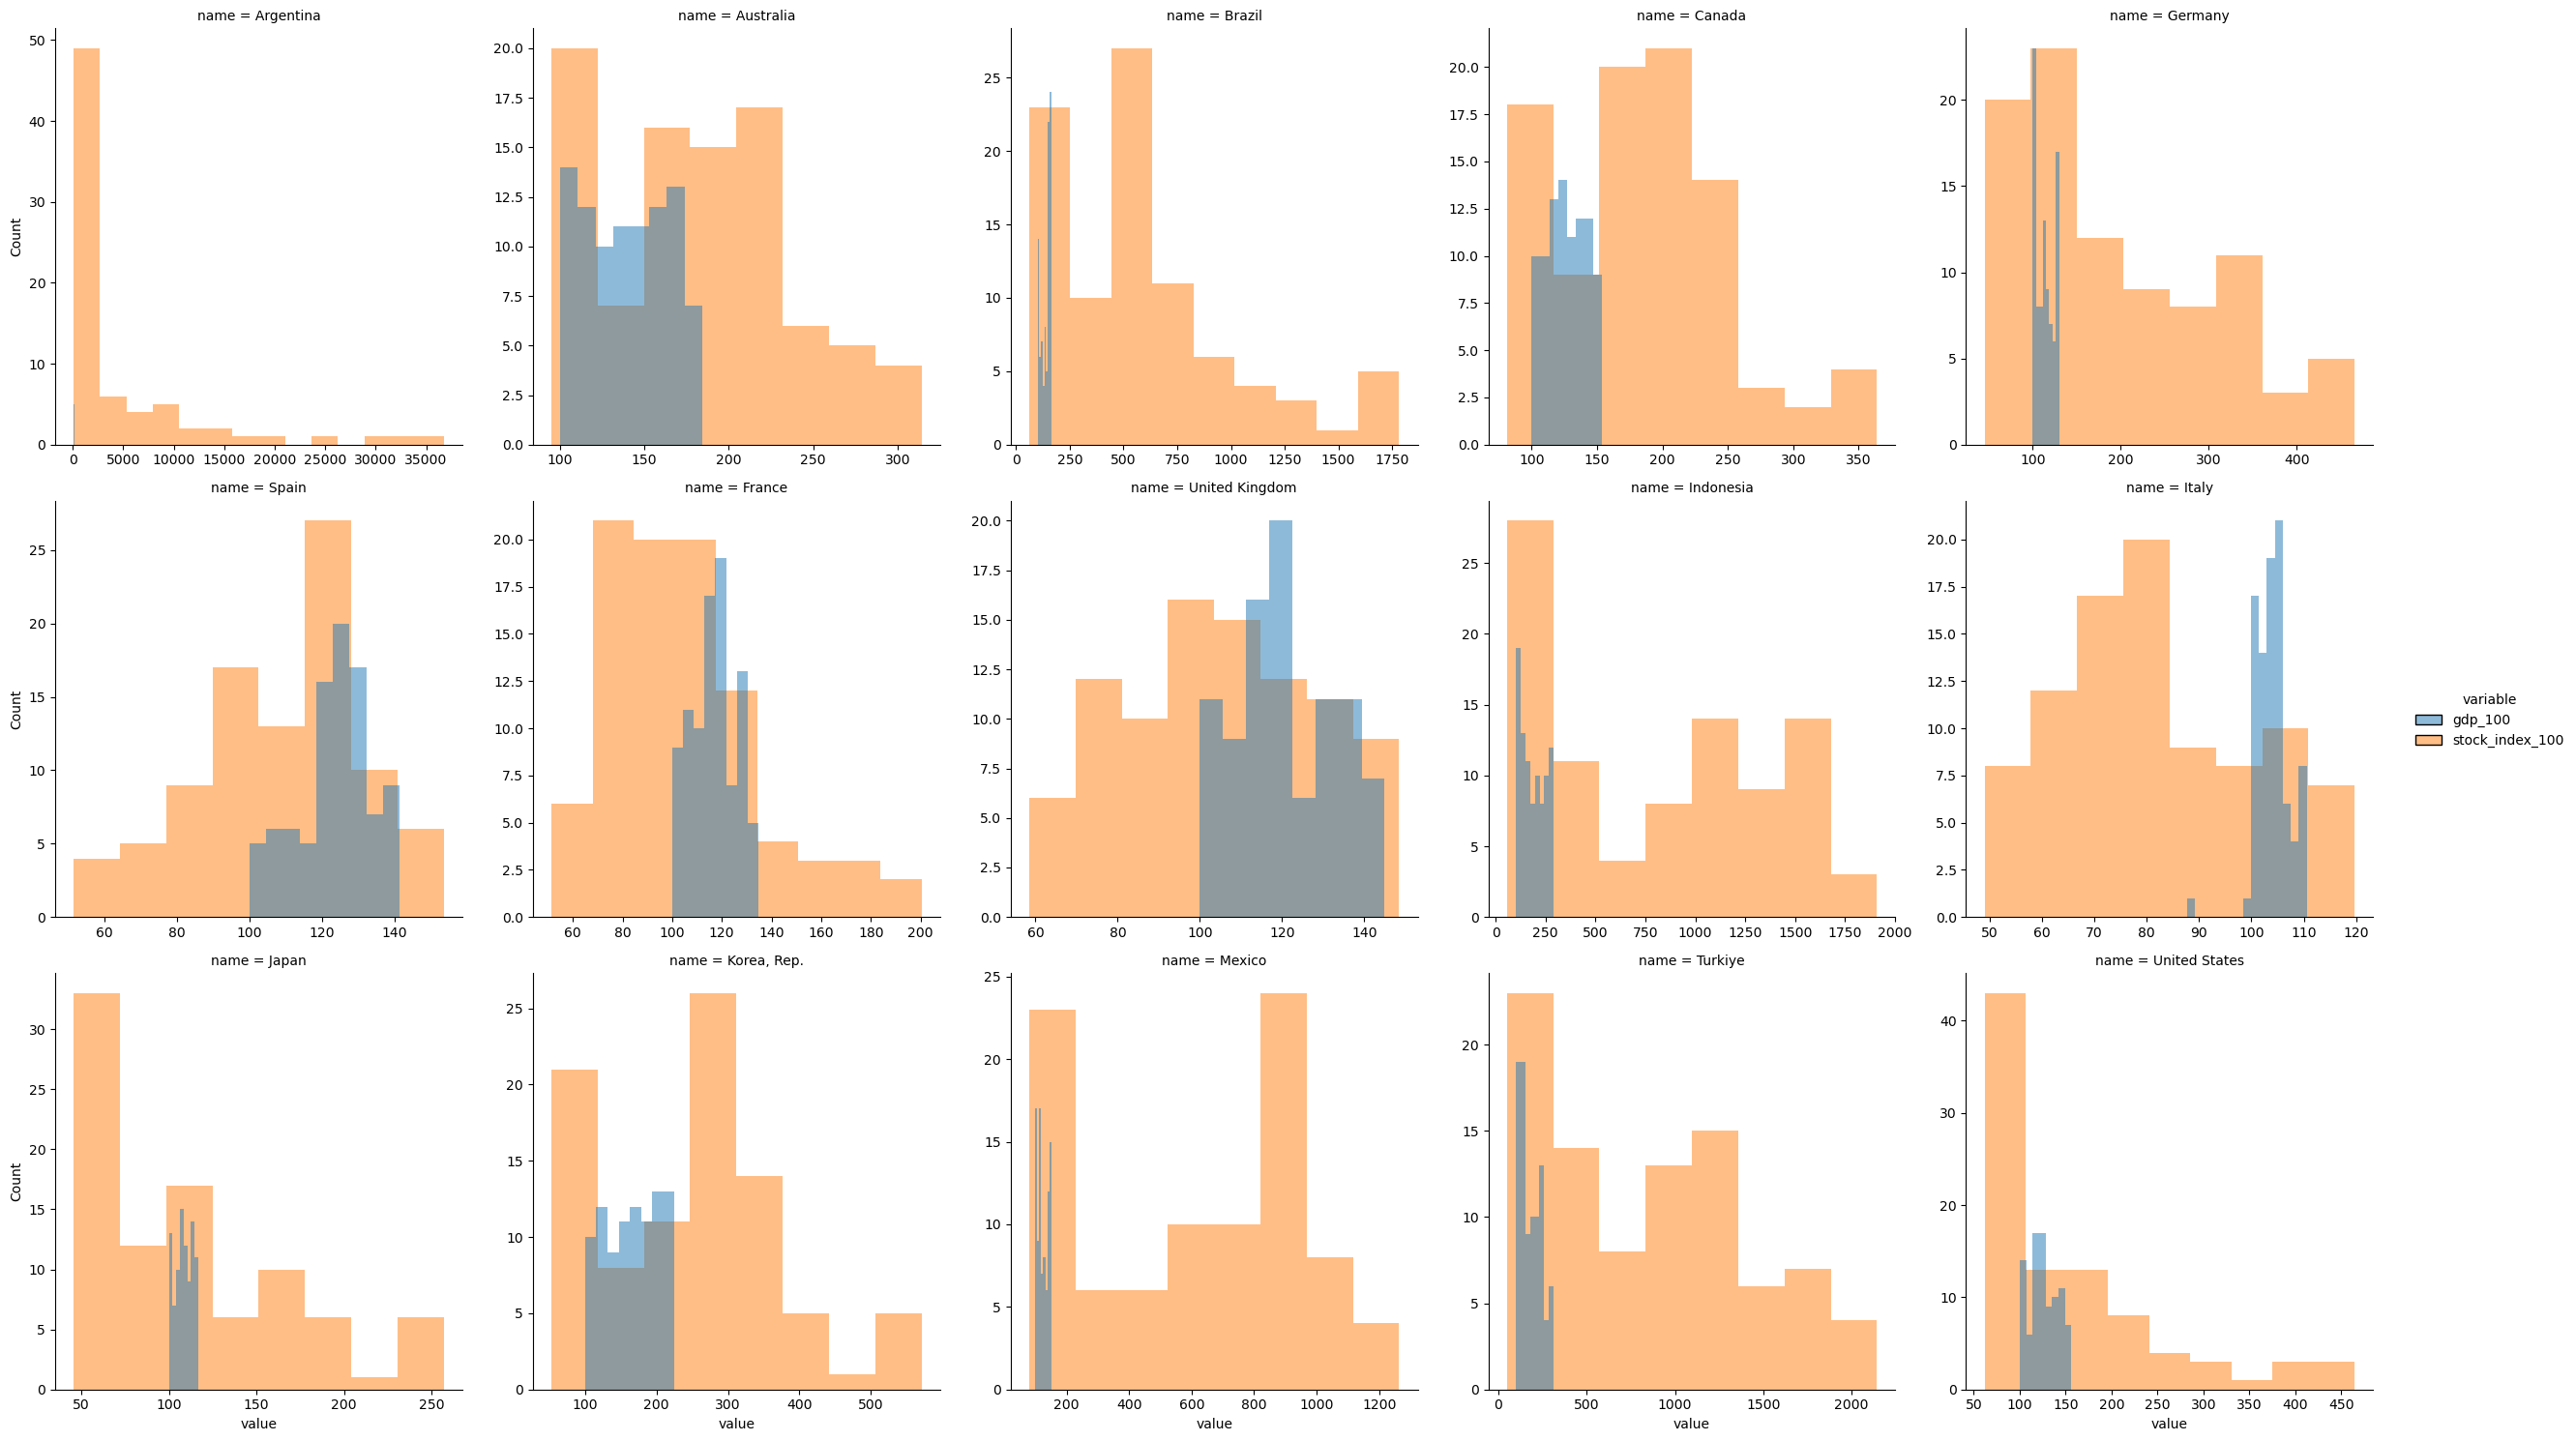

In [50]:
sns.displot(data=ad1, x="value", hue="variable", col="name", col_wrap=5, kind="hist", facet_kws=dict(sharey=False, sharex=False), common_bins=False)